In [ ]:
!git clone https://github.com/ITMO-NSS-team/BAMT.git

In [ ]:
import sys
sys.path.append('/content/BAMT')

In [ ]:
!pip install -r /content/BAMT/requirements.txt

In [ ]:
import pandas as pd
import seaborn as sns

from visualization.visualization import draw_BN
from bayesian.sampling import generate_synthetics
from sklearn.model_selection import train_test_split
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import discretization, get_nodes_sign, get_nodes_type
from bayesian.save_bn import save_structure, save_params, read_structure, read_params

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
lunar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/University/Multivariate/lunar_finale.csv',
                    index_col=0)

In [ ]:
lunar['Saros Number'].value_counts()

 65     86
 47     86
 45     85
 27     85
 26     85
        ..
-18      6
-19      5
-20      3
 182     3
 183     2
Name: Saros Number, Length: 204, dtype: int64

In [ ]:
lunar['Lunation Number'].value_counts()

-49456    1
-8281     1
-8322     1
-8316     1
-8310     1
         ..
-28874    1
-28869    1
-28863    1
-28857    1
 12378    1
Name: Lunation Number, Length: 12064, dtype: int64

In [ ]:
lunar.columns

Index(['Delta T (s)', 'Lunation Number', 'Saros Number', 'Eclipse Type',
       'Quincena Solar Eclipse', 'Gamma', 'Penumbral Magnitude',
       'Umbral Magnitude', 'Penumbral Eclipse Duration (m)',
       'Partial Eclipse Duration (m)', 'Total Eclipse Duration (m)',
       'Latitude3', 'Longitude3', 'Time JD'],
      dtype='object')

In [ ]:
saros_value_counts = lunar['Saros Number'].value_counts()
saros_probable = saros_value_counts.index[(saros_value_counts > 50) == True].to_list()

In [ ]:
lunar_subset = lunar[lunar['Saros Number'].isin(saros_probable)]

In [ ]:
lunar_subset = lunar_subset[['Saros Number', 'Eclipse Type',
                             'Quincena Solar Eclipse', 'Gamma', 'Penumbral Magnitude',
                             'Umbral Magnitude', 'Penumbral Eclipse Duration (m)', 'Partial Eclipse Duration (m)',
                             'Total Eclipse Duration (m)']]

In [ ]:
lunar_train, lunar_test = train_test_split(lunar_subset, test_size=0.3)
lunar_target = ['Penumbral Magnitude', 'Umbral Magnitude', 'Saros Number', 'Penumbral Eclipse Duration (m)']

Correlation based structure

In [ ]:
lunar_corr = lunar_train.corr()
lunar_corr

,Saros Number,Eclipse Type,Quincena Solar Eclipse,Gamma,Penumbral Magnitude,Umbral Magnitude,Penumbral Eclipse Duration (m),Partial Eclipse Duration (m),Total Eclipse Duration (m)
Saros Number,1.000000,-0.002676,0.046701,0.018166,-0.003639,-0.003927,0.004567,-0.002671,-0.013896
Eclipse Type,-0.002676,1.000000,0.190123,-0.015123,0.925469,0.925722,0.820756,0.931660,0.714410
Quincena Solar Eclipse,0.046701,0.190123,1.000000,-0.013379,0.228195,0.202736,0.235695,0.185010,0.276018
Gamma,0.018166,-0.015123,-0.013379,1.000000,-0.005537,-0.004774,-0.016391,-0.002785,0.000220
Penumbral Magnitude,-0.003639,0.925469,0.228195,-0.005537,1.000000,0.998274,0.903578,0.952520,0.791556
Umbral Magnitude,-0.003927,0.925722,0.202736,-0.004774,0.998274,1.000000,0.890657,0.950547,0.791419
Penumbral Eclipse Duration (m),0.004567,0.820756,0.235695,-0.016391,0.903578,0.890657,1.000000,0.855756,0.540178
Partial Eclipse Duration (m),-0.002671,0.931660,0.185010,-0.002785,0.952520,0.950547,0.855756,1.000000,0.680296
Total Eclipse Duration (m),-0.013896,0.714410,0.276018,0.000220,0.791556,0.791419,0.540178,0.680296,1.000000


In [ ]:
lunar_corr[(lunar_corr < 0.5)] = ' '
lunar_corr

,Saros Number,Eclipse Type,Quincena Solar Eclipse,Gamma,Penumbral Magnitude,Umbral Magnitude,Penumbral Eclipse Duration (m),Partial Eclipse Duration (m),Total Eclipse Duration (m)
Saros Number,1.0,,,,,,,,
Eclipse Type,,1.0,,,0.925478,0.925515,0.820876,0.931976,0.715722
Quincena Solar Eclipse,,,1.0,,,,,,
Gamma,,,,1.0,,,,,
Penumbral Magnitude,,0.925478,,,1.0,0.998278,0.902865,0.952366,0.794089
Umbral Magnitude,,0.925515,,,0.998278,1.0,0.890246,0.950429,0.793771
Penumbral Eclipse Duration (m),,0.820876,,,0.902865,0.890246,1.0,0.855224,0.541892
Partial Eclipse Duration (m),,0.931976,,,0.952366,0.950429,0.855224,1.0,0.682236
Total Eclipse Duration (m),,0.715722,,,0.794089,0.793771,0.541892,0.682236,1.0


In [ ]:
nodes_type = get_nodes_type(lunar_subset)
nodes_type

{'Saros Number': 'disc',
 'Eclipse Type': 'disc',
 'Quincena Solar Eclipse': 'disc',
 'Gamma': 'cont',
 'Penumbral Magnitude': 'cont',
 'Umbral Magnitude': 'cont',
 'Penumbral Eclipse Duration (m)': 'cont',
 'Partial Eclipse Duration (m)': 'cont',
 'Total Eclipse Duration (m)': 'cont'}

In [ ]:
nodes_sign = get_nodes_sign(lunar_subset)
nodes_sign

{'Gamma': 'neg',
 'Penumbral Magnitude': 'pos',
 'Umbral Magnitude': 'neg',
 'Penumbral Eclipse Duration (m)': 'pos',
 'Partial Eclipse Duration (m)': 'pos',
 'Total Eclipse Duration (m)': 'pos'}

In [ ]:
discrete_data, coder = discretization(lunar_train, 'equal_frequency', list(nodes_sign.keys()))

In [ ]:
bn = {'V': lunar_subset.columns.to_list(),
      'E': [['Penumbral Magnitude', 'Eclipse Type'],
            ['Umbral Magnitude', 'Eclipse Type'],
            ['Partial Eclipse Duration (m)', 'Eclipse Type'],
            ['Penumbral Eclipse Duration (m)', 'Eclipse Type'],
            ['Total Eclipse Duration (m)', 'Eclipse Type'],
            ['Umbral Magnitude', 'Penumbral Magnitude'],
            ['Penumbral Eclipse Duration (m)', 'Penumbral Magnitude'],
            ['Partial Eclipse Duration (m)', 'Penumbral Magnitude'],
            ['Total Eclipse Duration (m)', 'Penumbral Magnitude'],
            ['Penumbral Eclipse Duration (m)', 'Umbral Magnitude'],
            ['Partial Eclipse Duration (m)', 'Umbral Magnitude'],
            ['Total Eclipse Duration (m)', 'Umbral Magnitude'],
            ['Partial Eclipse Duration (m)', 'Penumbral Eclipse Duration (m)'],
            ['Total Eclipse Duration (m)', 'Penumbral Eclipse Duration (m)'],
            ['Total Eclipse Duration (m)', 'Partial Eclipse Duration (m)']]}

In [ ]:
lunar_train['Eclipse Type'] = lunar_train['Eclipse Type'].astype('str')
lunar_train['Saros Number'] = lunar_train['Saros Number'].astype('str')
lunar_train['Quincena Solar Eclipse'] = lunar_train['Quincena Solar Eclipse'].astype('str')
lunar_test['Eclipse Type'] = lunar_test['Eclipse Type'].astype('str')
lunar_test['Saros Number'] = lunar_test['Saros Number'].astype('str')
lunar_test['Quincena Solar Eclipse'] = lunar_test['Quincena Solar Eclipse'].astype('str')

In [ ]:
draw_BN(bn, nodes_type, 'eslipse_bn_hc_k2')

In [ ]:
params = parameter_learning(lunar_train, nodes_type, bn, 'simple')
save_structure(bn, 'bayes_structure_correlation')
skel = read_structure('bayes_structure_correlation')

In [ ]:
save_params(params, 'bayes_params_correlation')
params = read_params('bayes_params_correlation')

In [ ]:
bayes_correlation = HyBayesianNetwork(skel, params)

In [ ]:
synth_df = generate_synthetics(bayes_correlation, nodes_sign, 'simple', 1000)

<AxesSubplot:xlabel='Penumbral Magnitude', ylabel='Density'>

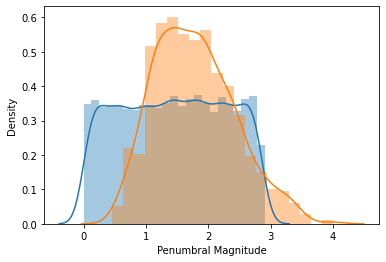

In [ ]:
sns.distplot(lunar_subset['Penumbral Magnitude'])
sns.distplot(synth_df['Penumbral Magnitude'])

<AxesSubplot:xlabel='Umbral Magnitude', ylabel='Density'>

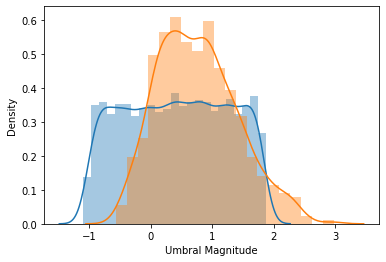

In [ ]:
sns.distplot(lunar_subset['Umbral Magnitude'])
sns.distplot(synth_df['Umbral Magnitude'])

<AxesSubplot:xlabel='Saros Number', ylabel='Density'>

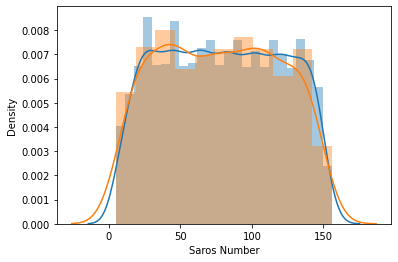

In [ ]:
sns.distplot(lunar_subset['Saros Number'])
sns.distplot(synth_df['Saros Number'])

<AxesSubplot:xlabel='Penumbral Eclipse Duration (m)', ylabel='Density'>

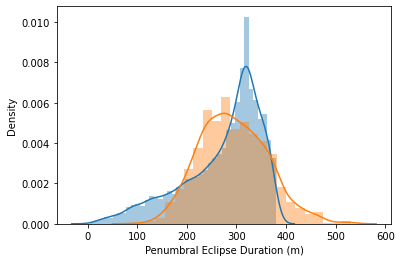

In [ ]:
sns.distplot(lunar_subset['Penumbral Eclipse Duration (m)'])
sns.distplot(synth_df['Penumbral Eclipse Duration (m)']) 

In [ ]:
accuracy = calculate_acc(bayes_correlation, lunar_test, lunar_target, 'simple')

In [ ]:
accuracy[:2]

({'Saros Number': 0.0},
 {'Penumbral Magnitude': 0.027,
  'Umbral Magnitude': 0.136,
  'Penumbral Eclipse Duration (m)': 40.755})

Hill-climbing + K2

In [ ]:
bn = structure_learning(discrete_data, 'HC', nodes_type, 'K2')

In [ ]:
bn

{'V': ['Saros Number',
  'Eclipse Type',
  'Quincena Solar Eclipse',
  'Gamma',
  'Penumbral Magnitude',
  'Umbral Magnitude',
  'Penumbral Eclipse Duration (m)',
  'Partial Eclipse Duration (m)',
  'Total Eclipse Duration (m)'],
 'E': [['Eclipse Type', 'Partial Eclipse Duration (m)'],
  ['Eclipse Type', 'Quincena Solar Eclipse'],
  ['Eclipse Type', 'Penumbral Magnitude'],
  ['Eclipse Type', 'Saros Number'],
  ['Eclipse Type', 'Umbral Magnitude'],
  ['Eclipse Type', 'Penumbral Eclipse Duration (m)'],
  ['Quincena Solar Eclipse', 'Saros Number'],
  ['Quincena Solar Eclipse', 'Penumbral Eclipse Duration (m)'],
  ['Quincena Solar Eclipse', 'Partial Eclipse Duration (m)'],
  ['Gamma', 'Total Eclipse Duration (m)'],
  ['Penumbral Magnitude', 'Umbral Magnitude'],
  ['Penumbral Magnitude', 'Gamma'],
  ['Penumbral Magnitude', 'Penumbral Eclipse Duration (m)'],
  ['Umbral Magnitude', 'Gamma'],
  ['Partial Eclipse Duration (m)', 'Penumbral Magnitude'],
  ['Partial Eclipse Duration (m)', 'Umbral 

In [ ]:
draw_BN(bn, nodes_type, 'eslipse_bn_hc_k2')  

In [ ]:
params = parameter_learning(lunar_train, nodes_type, bn, 'simple')
save_structure(bn, 'bayes_structure_hc_k2')
skel = read_structure('bayes_structure_hc_k2')

In [ ]:
save_params(params, 'bayes_params_hc_k2')
params = read_params('bayes_params_hc_k2')

In [ ]:
bayes_hc_k2 = HyBayesianNetwork(skel, params)

In [ ]:
synth_df = generate_synthetics(bayes_hc_k2, nodes_sign, 'simple', 1000)

<AxesSubplot:xlabel='Penumbral Magnitude', ylabel='Density'>

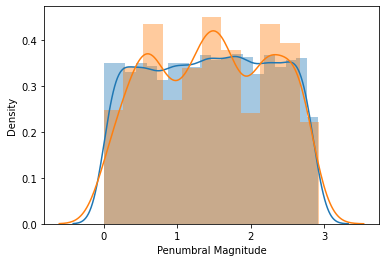

In [ ]:
sns.distplot(lunar_train['Penumbral Magnitude'])
sns.distplot(synth_df['Penumbral Magnitude'])

<AxesSubplot:xlabel='Umbral Magnitude', ylabel='Density'>

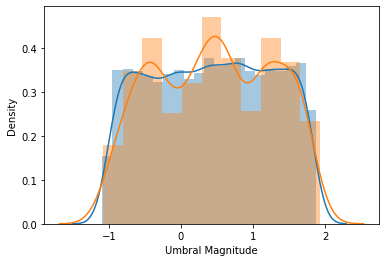

In [ ]:
sns.distplot(lunar_train['Umbral Magnitude'])
sns.distplot(synth_df['Umbral Magnitude'])

<AxesSubplot:xlabel='Saros Number', ylabel='Density'>

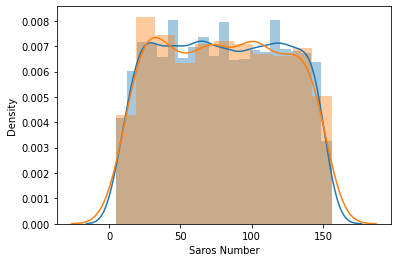

In [ ]:
sns.distplot(lunar_train['Saros Number'])
sns.distplot(synth_df['Saros Number'])

<AxesSubplot:xlabel='Penumbral Eclipse Duration (m)', ylabel='Density'>

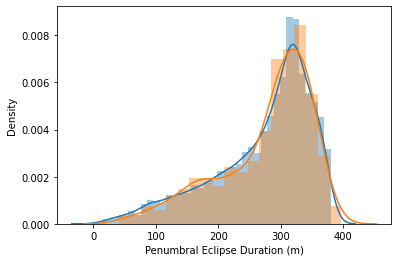

In [ ]:
sns.distplot(lunar_train['Penumbral Eclipse Duration (m)'])
sns.distplot(synth_df['Penumbral Eclipse Duration (m)']) 

In [ ]:
accuracy = calculate_acc(bayes_hc_k2, lunar_test, lunar_target, 'simple')

In [ ]:
print(accuracy[:2])

({'Saros Number': 0.03}, {'Penumbral Magnitude': 0.172, 'Umbral Magnitude': 0.041, 'Penumbral Eclipse Duration (m)': 8.801})


Evo + MI

In [ ]:
bn = structure_learning(discrete_data, 'evo', nodes_type, 'MI')

Best metric is 12.319700000000001
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 12.319700000000001
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.5 min
Best metric is 11.4627
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 0.6 min
Best metric is 11.4292
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.8 min
Best metric is 11.023599999999998
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 1.0 min
Best metric is 10.936999999999998
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 1.2 min
Best metric is 10.924399999999999
Generation num: 6
max_depth: 6, no improvements: 0
spent time: 1.3 min
Best metric is 10.838799999999999
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 1.6 min
Best metric is 10.808
Generation num: 8
max_depth: 6, no improvements: 0
spent time: 1.7 min
Best metric is 10.7745
Generation num: 9
max_depth: 6, no improvements: 0
spent time: 2.0

In [ ]:
bn

{'V': ['Saros Number',
  'Eclipse Type',
  'Quincena Solar Eclipse',
  'Gamma',
  'Penumbral Magnitude',
  'Umbral Magnitude',
  'Penumbral Eclipse Duration (m)',
  'Partial Eclipse Duration (m)',
  'Total Eclipse Duration (m)'],
 'E': [['Gamma', 'Penumbral Eclipse Duration (m)'],
  ['Umbral Magnitude', 'Gamma'],
  ['Total Eclipse Duration (m)', 'Gamma'],
  ['Total Eclipse Duration (m)', 'Partial Eclipse Duration (m)'],
  ['Partial Eclipse Duration (m)', 'Penumbral Eclipse Duration (m)'],
  ['Partial Eclipse Duration (m)', 'Penumbral Magnitude'],
  ['Saros Number', 'Gamma'],
  ['Saros Number', 'Penumbral Magnitude'],
  ['Saros Number', 'Partial Eclipse Duration (m)'],
  ['Eclipse Type', 'Penumbral Magnitude'],
  ['Eclipse Type', 'Partial Eclipse Duration (m)'],
  ['Quincena Solar Eclipse', 'Penumbral Eclipse Duration (m)'],
  ['Quincena Solar Eclipse', 'Gamma'],
  ['Quincena Solar Eclipse', 'Penumbral Magnitude'],
  ['Quincena Solar Eclipse', 'Partial Eclipse Duration (m)']]}

In [ ]:
draw_BN(bn, nodes_type, 'eslipse_bn_evo_mi')

In [ ]:
params = parameter_learning(lunar_train, nodes_type, bn, 'simple')
save_structure(bn, 'bayes_structure_evo_mi')
skel = read_structure('bayes_structure_evo_mi')

In [ ]:
save_params(params, 'bayes_params_evo_mi')
params = read_params('bayes_params_evo_mi')

In [ ]:
bayes_evo_mi = HyBayesianNetwork(skel, params)

In [ ]:
synth_df = generate_synthetics(bayes_evo_mi, nodes_sign, 'simple', 1000)

<AxesSubplot:xlabel='Penumbral Magnitude', ylabel='Density'>

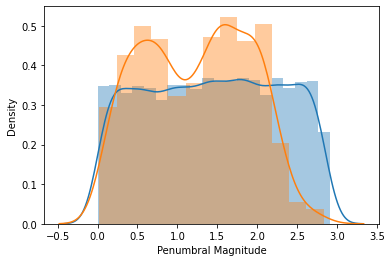

In [ ]:
sns.distplot(lunar_train['Penumbral Magnitude'])
sns.distplot(synth_df['Penumbral Magnitude'])

<AxesSubplot:xlabel='Umbral Magnitude', ylabel='Density'>

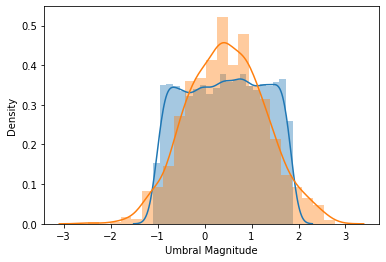

In [ ]:
sns.distplot(lunar_train['Umbral Magnitude'])
sns.distplot(synth_df['Umbral Magnitude'])

<AxesSubplot:xlabel='Saros Number', ylabel='Density'>

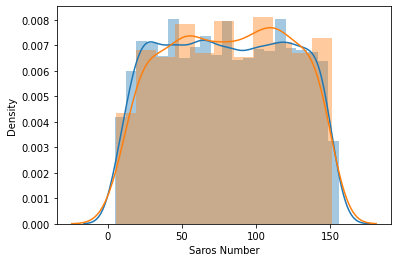

In [ ]:
sns.distplot(lunar_train['Saros Number'])
sns.distplot(synth_df['Saros Number'])

<AxesSubplot:xlabel='Penumbral Eclipse Duration (m)', ylabel='Density'>

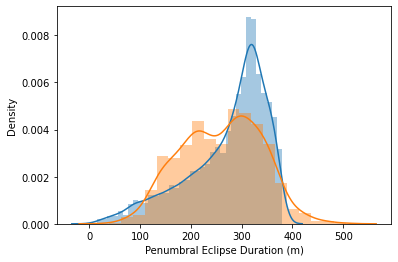

In [ ]:
sns.distplot(lunar_train['Penumbral Eclipse Duration (m)'])
sns.distplot(synth_df['Penumbral Eclipse Duration (m)'])

In [ ]:
accuracy = calculate_acc(bayes_evo_mi, lunar_test, lunar_target, 'simple')

In [ ]:
accuracy[:2] 

({'Saros Number': 0.01},
 {'Penumbral Magnitude': 0.167,
  'Umbral Magnitude': 0.838,
  'Penumbral Eclipse Duration (m)': 39.342})